In [3]:
import pandas as pd
merged_df_encoded = pd.read_csv('../../data/filtered_merged_encoded_data.csv')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters from Randomized Search: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}

Random Forest Model Evaluation (after Randomized Search Tuning):
Accuracy: 0.8371531966224367

Confusion Matrix:
 [[4041  551]
 [ 259  123]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      4592
           1       0.18      0.32      0.23       382

    accuracy                           0.84      4974
   macro avg       0.56      0.60      0.57      4974
weighted avg       0.88      0.84      0.86      4974

ROC-AUC Score: 0.7354832328474743


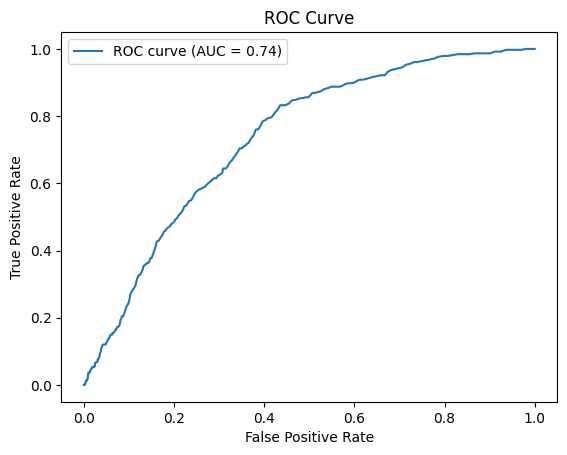

In [5]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN  # For resampling
import matplotlib.pyplot as plt
# Import train_test_split function
from sklearn.model_selection import train_test_split
import numpy as np

# Define features (X) and target (y)
X = merged_df_encoded.drop(columns=['HY_YN'])  # Drop target variable from features
y = merged_df_encoded['HY_YN']  # Define target variable

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTEENN to the training data only
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# Set up the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': np.arange(100, 301, 50),       # Reduced range of number of trees
    'max_depth': [10, 20, 30, None],               # Maximum depth options
    'min_samples_split': [2, 5, 10],               # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],                 # Minimum samples required at a leaf node
    'class_weight': ['balanced', 'balanced_subsample']  # Class weight options
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_dist, 
                                   n_iter=20,  # Number of random combinations to try
                                   cv=5,       # 5-fold cross-validation
                                   scoring='f1', 
                                   n_jobs=-1, 
                                   random_state=42, 
                                   verbose=1)

# Fit RandomizedSearchCV to the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best model
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_

print("Best Parameters from Randomized Search:", best_params)

# Evaluate the tuned model on the test set
y_pred = best_rf_model.predict(X_test)
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Model evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Display the evaluation results
print("\nRandom Forest Model Evaluation (after Randomized Search Tuning):")
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("ROC-AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
